## **0. Setup Library**

In [ ]:
import os
import kagglehub
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt
import seaborn as sns

# untuk reweighting
from collections import Counter

# imbalanced-learn
from imblearn.over_sampling import SMOTE
print('Libraries loaded')

Libraries loaded


## **1. Load data**

In [ ]:
path = kagglehub.dataset_download("rikdifos/credit-card-approval-prediction")
print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'credit-card-approval-prediction' dataset.
Path to dataset files: /kaggle/input/credit-card-approval-prediction
['credit_record.csv', 'application_record.csv']


In [ ]:
df1 = pd.read_csv(os.path.join(path, 'application_record.csv'))
df2 = pd.read_csv(os.path.join(path, 'credit_record.csv'))
new_data = pd.merge(df1, df2, on='ID', how='inner')
display(new_data.head())

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
new_data['OCCUPATION_TYPE'] = new_data['OCCUPATION_TYPE'].fillna("Unknown")

## **2. Bentuk variabel target (target) berdasarkan STATUS di credit_record**

In [ ]:
# Tandai dep_value di level record
new_data['dep_value'] = np.where(new_data['STATUS'].isin(['2','3','4','5']), 'Yes', 'No')

# Group by ID: cek apakah ada dep_value Yes
cpunt = new_data.groupby('ID')['dep_value'].apply(lambda s: 'Yes' if (s=='Yes').any() else 'No').reset_index()
cpunt.columns = ['ID', 'dep_value']

# Lihat distribusi
print(cpunt['dep_value'].value_counts())
print(cpunt['dep_value'].value_counts(normalize=True))

# Buat kolom target biner
new_data['target'] = new_data['dep_value'].map({'Yes':1, 'No':0})

# Cek
print(new_data['target'].value_counts())

dep_value
No     35841
Yes      616
Name: count, dtype: int64
dep_value
No     0.983103
Yes    0.016897
Name: proportion, dtype: float64
target
0    774887
1      2828
Name: count, dtype: int64


## 3. Eksplorasi singkat dan distribusi protected attribute (CODE_GENDER)

Distribusi gender:
CODE_GENDER
F    518851
M    258864
Name: count, dtype: int64

Distribusi target keseluruhan:
target
0    0.996364
1    0.003636
Name: proportion, dtype: float64

Crosstab target vs gender:
target              0         1
CODE_GENDER                    
F            0.996868  0.003132
M            0.995353  0.004647


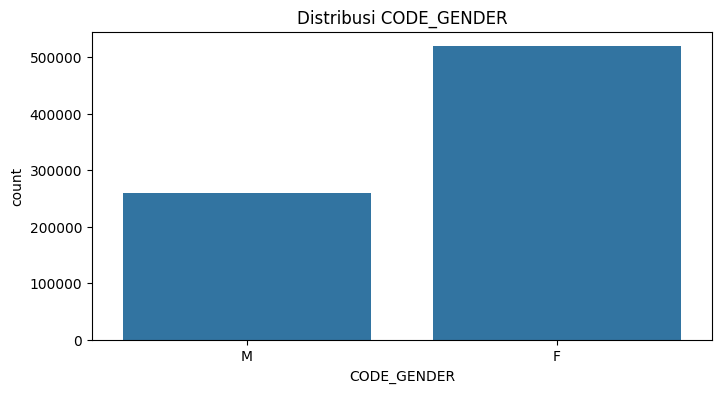

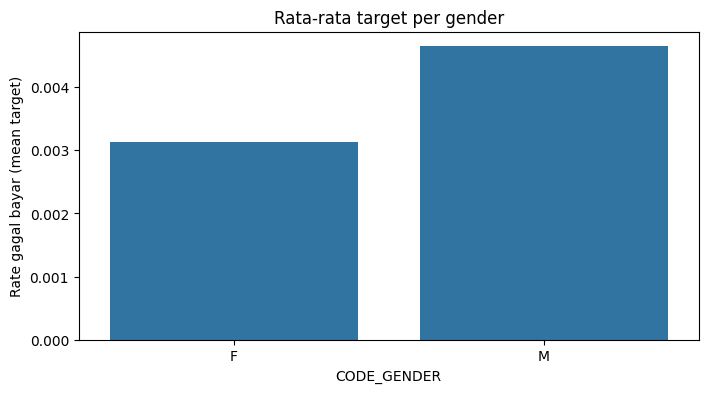

In [ ]:
# Tampilkan beberapa baris
new_data[['ID','CODE_GENDER','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','NAME_HOUSING_TYPE','target']].head()

# Distribusi gender dan target per gender
print('Distribusi gender:')
print(new_data['CODE_GENDER'].value_counts())
print('\nDistribusi target keseluruhan:')
print(new_data['target'].value_counts(normalize=True))

# Crosstab
print('\nCrosstab target vs gender:')
print(pd.crosstab(new_data['CODE_GENDER'], new_data['target'], normalize='index'))

# Visualisasi sederhana
plt.figure(figsize=(8,4))
sns.countplot(data=new_data, x='CODE_GENDER')
plt.title('Distribusi CODE_GENDER')
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x='CODE_GENDER', y='target', data=new_data.groupby('CODE_GENDER')['target'].mean().reset_index())
plt.ylabel('Rate gagal bayar (mean target)')
plt.title('Rata-rata target per gender')
plt.show()

## **4. Preprocessing**

In [ ]:
# Pilih fitur
features = ['AMT_INCOME_TOTAL','NAME_HOUSING_TYPE','CNT_FAM_MEMBERS','CODE_GENDER',
'FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE']

df = new_data.copy()
df = df[features + ['target']].copy()

# Imputasi OCCUPATION_TYPE: modus global
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')

# Categorical and numerical lists
num_features = ['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS']
cat_features = [c for c in features if c not in num_features]

# Pipelines
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)])

# Split
X = df[features]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit preprocessor on train
preprocessor.fit(X_train)
X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

print('Preprocessing selesai. Shape setelah transform: ', X_train_p.shape)

Preprocessing selesai. Shape setelah transform:  (622172, 43)


## **5. Baseline modeling (Logistic Regression & Random Forest)**

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_p, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_p, y_train)

# Prediksi
y_pred_lr = lr.predict(X_test_p)
y_proba_lr = lr.predict_proba(X_test_p)[:,1]

y_pred_rf = rf.predict(X_test_p)
y_proba_rf = rf.predict_proba(X_test_p)[:,1]

# Fungsi evaluasi
def eval_print(y_true, y_pred, y_proba=None):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))
    if y_proba is not None:
        print('ROC AUC:', roc_auc_score(y_true, y_proba))


print('Logistic Regression:')
eval_print(y_test, y_pred_lr, y_proba_lr)
print('\nRandom Forest:')
eval_print(y_test, y_pred_rf, y_proba_rf)

Logistic Regression:
Accuracy: 0.9963611348630282
Precision: 0.0
Recall: 0.0
F1: 0.0
ROC AUC: 0.6005131309693258

Random Forest:
Accuracy: 0.9965282912120764
Precision: 0.6857142857142857
Recall: 0.08480565371024736
F1: 0.1509433962264151
ROC AUC: 0.94703502794932


## **Kinerja Umum Model**

| Model               | Accuracy | Precision | Recall | F1     | ROC AUC |
| ------------------- | -------- | --------- | ------ | ------ | ------- |
| Logistic Regression | 0.9964   | 0.000     | 0.000  | 0.000  | 0.6005  |
| Random Forest       | 0.9965   | 0.6857    | 0.0848 | 0.1509 | 0.9470  |

### Interpretasi

- **Accuracy tinggi (~99.6%) tetapi menipu.**  
  Nilai ini tampak bagus, namun **precision, recall, dan F1 mendekati 0** → model hampir selalu memprediksi kelas mayoritas (kemungkinan besar negatif).
- **Random Forest lebih baik secara diskriminatif.**  
  Recall kecil (0.08) namun mulai mendeteksi sebagian kasus positif. ROC AUC tinggi (0.947) menunjukkan model punya potensi prediktif meski threshold default belum optimal.

**Kesimpulan:**  
Logistic Regression gagal karena *class imbalance*, sedangkan Random Forest mampu mengenali sebagian pola walau recall rendah.

---

## **6. Evaluasi per-group (fairness check awal)**

In [ ]:
# Rekonstruksi X_test sebagai dataframe untuk menyertakan CODE_GENDER
X_test_df = X_test.reset_index(drop=True).copy()
X_test_df['y_true'] = y_test.reset_index(drop=True)
X_test_df['y_pred_lr'] = y_pred_lr
X_test_df['y_proba_lr'] = y_proba_lr
X_test_df['y_pred_rf'] = y_pred_rf
X_test_df['y_proba_rf'] = y_proba_rf

# Fungsi metrik per group
def group_metrics(df, group_col, y_col='y_true', pred_col='y_pred_lr', proba_col='y_proba_lr'):
    groups = df[group_col].unique()
    res = {}
    for g in groups:
        d = df[df[group_col]==g]
        tn, fp, fn, tp = confusion_matrix(d[y_col], d[pred_col], labels=[0,1]).ravel()
        acc = accuracy_score(d[y_col], d[pred_col])
        prec = precision_score(d[y_col], d[pred_col], zero_division=0)
        rec = recall_score(d[y_col], d[pred_col], zero_division=0)
        f1 = f1_score(d[y_col], d[pred_col], zero_division=0)
        auc = roc_auc_score(d[y_col], d[proba_col]) if len(d[y_col].unique())>1 else np.nan
        res[g] = {'n':len(d),'acc':acc,'prec':prec,'rec':rec,'f1':f1,'auc':auc,'tp':tp,'fp':fp,'tn':tn,'fn':fn}
    return pd.DataFrame(res).T


print('Metrik per gender (Logistic Regression):')
print(group_metrics(X_test_df, 'CODE_GENDER', pred_col='y_pred_lr', proba_col='y_proba_lr'))


print('\nMetrik per gender (Random Forest):')
print(group_metrics(X_test_df, 'CODE_GENDER', pred_col='y_pred_rf', proba_col='y_proba_rf'))

Metrik per gender (Logistic Regression):
          n       acc  prec  rec   f1       auc   tp   fp        tn     fn
F  103696.0  0.996818   0.0  0.0  0.0  0.624017  0.0  0.0  103366.0  330.0
M   51847.0  0.995448   0.0  0.0  0.0  0.544937  0.0  0.0   51611.0  236.0

Metrik per gender (Random Forest):
          n       acc      prec       rec        f1       auc    tp    fp  \
F  103696.0  0.996904  0.636364  0.063636  0.115702  0.941308  21.0  12.0   
M   51847.0  0.995776  0.729730  0.114407  0.197802  0.954635  27.0  10.0   

         tn     fn  
F  103354.0  309.0  
M   51601.0  209.0  


## Metrik per Gender

| Model               | Gender | Accuracy | Precision | Recall | F1    | ROC AUC | TP | FP | FN  |
| ------------------- | ------ | -------- | --------- | ------ | ----- | ------- | -- | -- | --- |
| Logistic Regression | F      | 0.9968   | 0.0       | 0.0    | 0.0   | 0.6240  | 0  | 0  | 330 |
| Logistic Regression | M      | 0.9954   | 0.0       | 0.0    | 0.0   | 0.5449  | 0  | 0  | 236 |
| Random Forest       | F      | 0.9969   | 0.636     | 0.064  | 0.116 | 0.941   | 21 | 12 | 309 |
| Random Forest       | M      | 0.9958   | 0.730     | 0.114  | 0.198 | 0.955   | 27 | 10 | 209 |

### Interpretasi

- Logistic Regression gagal total, tidak ada TP sama sekali.
- Random Forest:
  - Laki-laki (M) sedikit lebih baik: recall 0.11 vs perempuan (F) 0.06.
  - Akurasi hampir sama (~99.6%), menunjukkan ketidakseimbangan label masih besar.
  - ROC AUC lebih tinggi pada laki-laki (0.955 vs 0.941), model sedikit lebih baik membedakan kelas positif/negatif pada laki-laki.

Kesimpulan per gender: Random Forest relatif adil, sedikit lebih sensitif pada laki-laki. Logistic Regression sama sekali tidak mengenali kasus positif.

---

## **7. Fairness metrics (Statistical Parity, Disparate Impact, Equal Opportunity)**

In [ ]:
def fairness_metrics(df, group_col='CODE_GENDER', y_col='y_true', pred_col='y_pred_lr'):
  vals = df[group_col].unique()
  if len(vals)!=2:
      print('Perhitungan sederhana diasumsikan dua grup. Grup:', vals)
  g1, g2 = vals[0], vals[1]
  # Probabilities of positive prediction
  p_g1 = df[df[group_col]==g1][pred_col].mean()
  p_g2 = df[df[group_col]==g2][pred_col].mean()
  # TPR
  tpr_g1 = recall_score(df[df[group_col]==g1][y_col], df[df[group_col]==g1][pred_col], zero_division=0)
  tpr_g2 = recall_score(df[df[group_col]==g2][y_col], df[df[group_col]==g2][pred_col], zero_division=0)
  metrics = {
    'group_1': g1,
    'group_2': g2,
    'p_pred_g1': p_g1,
    'p_pred_g2': p_g2,
    'stat_parity_diff': p_g1 - p_g2,
    'disparate_impact': (p_g2 / p_g1) if p_g1!=0 else np.nan,
    'tpr_g1': tpr_g1,
    'tpr_g2': tpr_g2,
    'equal_opp_diff': tpr_g2 - tpr_g1
  }
  return metrics


fm_lr = fairness_metrics(X_test_df, pred_col='y_pred_lr')
fm_rf = fairness_metrics(X_test_df, pred_col='y_pred_rf')


print('Fairness (LR):', fm_lr)
print('Fairness (RF):', fm_rf)

Fairness (LR): {'group_1': 'F', 'group_2': 'M', 'p_pred_g1': np.float64(0.0), 'p_pred_g2': np.float64(0.0), 'stat_parity_diff': np.float64(0.0), 'disparate_impact': nan, 'tpr_g1': 0.0, 'tpr_g2': 0.0, 'equal_opp_diff': 0.0}
Fairness (RF): {'group_1': 'F', 'group_2': 'M', 'p_pred_g1': np.float64(0.0003182379262459497), 'p_pred_g2': np.float64(0.0007136382047177272), 'stat_parity_diff': np.float64(-0.0003954002784717775), 'disparate_impact': np.float64(2.2424674932245283), 'tpr_g1': 0.06363636363636363, 'tpr_g2': 0.11440677966101695, 'equal_opp_diff': 0.05077041602465332}


## Fairness Metrics

| Model               | Stat. Parity Diff | Disparate Impact | Equal Opp. Diff | TPR F | TPR M |
| ------------------- | ---------------- | ---------------- | --------------- | ----- | ----- |
| Logistic Regression | 0.0000           | NaN              | 0.0000          | 0.0   | 0.0   |
| Random Forest       | -0.00039         | 2.24             | 0.0508          | 0.064 | 0.114 |

### Penjelasan

- Statistical Parity Difference (SPD) mendekati 0 → prediksi positif relatif seimbang.
- Disparate Impact (DI): RF = 2.24 → probabilitas perempuan diprediksi positif 2.24× lebih besar, namun jumlah prediksi sangat kecil.
- Equal Opportunity Difference (EOD): RF = 0.0507 → model sedikit lebih baik mengenali TP pada laki-laki.

Kesimpulan fairness: Logistic Regression tampak “adil” karena tidak memprediksi positif sama sekali (gagal model). Random Forest sedikit bias terhadap laki-laki (~5%).

---

## **8. Mitigasi: Reweighting (pre-processing)**

In [ ]:
# Hitung weights berdasarkan group dan label pada X_train
X_train2 = X_train.reset_index(drop=True).copy()
X_train2['target'] = y_train.reset_index(drop=True)

# group col ada di X_train2
weights = {}
group_vals = X_train2['CODE_GENDER'].unique()

# Cara sederhana: weight = 1 / (freq group * freq label within group)
for g in group_vals:
  for label in [0,1]:
    cnt = len(X_train2[(X_train2['CODE_GENDER']==g) & (X_train2['target']==label)])
    if cnt==0:
      weights[(g,label)] = 1.0
    else:
      weights[(g,label)] = 1.0 / cnt

# Assign sample weights
sample_weight = X_train2.apply(lambda r: weights[(r['CODE_GENDER'], r['target'])], axis=1).values

# Latih ulang Logistic Regression dengan sample_weight
lr_rw = LogisticRegression(max_iter=1000)
lr_rw.fit(X_train_p, y_train, sample_weight=sample_weight)

# Prediksi dengan model reweighted
y_pred_lr_rw = lr_rw.predict(X_test_p)
y_proba_lr_rw = lr_rw.predict_proba(X_test_p)[:,1]

# Evaluasi model reweighted
print('Logistic Regression (Reweighted):')
eval_print(y_test, y_pred_lr_rw, y_proba_lr_rw)

# Update X_test_df with reweighted predictions
X_test_df['y_pred_lr_rw'] = y_pred_lr_rw
X_test_df['y_proba_lr_rw'] = y_proba_lr_rw

Logistic Regression (Reweighted):
Accuracy: 0.5400371601422115
Precision: 0.004398949838006927
Recall: 0.5565371024734982
F1: 0.008728905145897414
ROC AUC: 0.5582800431961966


## Opsional

In [ ]:
# Pisahkan kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# OHE untuk kolom kategorikal
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Split train/test lagi (atau sesuaikan index)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Scaling numerik
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# =========================
# TANGANI CLASS IMBALANCE
# =========================
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_p, y_train)

print("Resampling dengan SMOTE selesai.")
print("Shape X_train_bal:", X_train_bal.shape)
print("Shape y_train_bal:", y_train_bal.shape)
print("Distribusi kelas di y_train_bal:", Counter(y_train_bal))

Resampling dengan SMOTE selesai.
Shape X_train_bal: (1239820, 43)
Shape y_train_bal: (1239820,)
Distribusi kelas di y_train_bal: Counter({0: 619910, 1: 619910})


In [ ]:
# =========================
# FUNCTION EVALUASI
# =========================
def eval_model(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC AUC': auc}

In [ ]:
# =========================
# RANDOM FOREST BASELINE
# =========================
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',  # handle imbalance
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
rf_scores = eval_model(y_test, y_pred_rf, y_proba_rf)
print("Random Forest Baseline:", rf_scores)

Random Forest Baseline: {'Accuracy': 0.9278977517471053, 'Precision': 0.032487487926947056, 'Recall': 0.6537102473498233, 'F1': 0.06189878711836052, 'ROC AUC': np.float64(0.88234623142871)}


In [ ]:
# =========================
# XGBOOST & LIGHTGBM
# =========================
# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # imbalance handling
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:,1]
xgb_scores = eval_model(y_test, y_pred_xgb, y_proba_xgb)
print("XGBoost:", xgb_scores)

# LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
lgb_clf.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_clf.predict(X_test_scaled)
y_proba_lgb = lgb_clf.predict_proba(X_test_scaled)[:,1]
lgb_scores = eval_model(y_test, y_pred_lgb, y_proba_lgb)
print("LightGBM:", lgb_scores)

XGBoost: {'Accuracy': 0.8953858418572356, 'Precision': 0.026357056694813027, 'Recall': 0.7720848056537103, 'F1': 0.05097398810218127, 'ROC AUC': np.float64(0.9187921615907853)}
[LightGBM] [Info] Number of positive: 2262, number of negative: 619910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 622172, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [ ]:
# =========================
# THRESHOLD TUNING (CALIBRATION CURVE)
# =========================
# Contoh threshold tuning untuk RF
thresholds = np.arange(0.01, 1.0, 0.01)
best_f1 = 0
best_thresh = 0.5
for t in thresholds:
    y_pred_thresh = (y_proba_rf >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Optimal Threshold RF: {best_thresh}, Best F1: {best_f1}")

# Prediksi dengan threshold optimal
y_pred_rf_opt = (y_proba_rf >= best_thresh).astype(int)
rf_opt_scores = eval_model(y_test, y_pred_rf_opt, y_proba_rf)
print("Random Forest with Threshold Tuning:", rf_opt_scores)

Optimal Threshold RF: 0.74, Best F1: 0.19741100323624594
Random Forest with Threshold Tuning: {'Accuracy': 0.9936223423747774, 'Precision': 0.18208955223880596, 'Recall': 0.21554770318021202, 'F1': 0.19741100323624594, 'ROC AUC': np.float64(0.88234623142871)}


In [ ]:
# =========================
# FAIRNESS PER GENDER
# =========================
def fairness_metrics(df_test, y_true, y_pred, group_col='CODE_GENDER'):
    df_eval = df_test.copy()
    df_eval['y_true'] = y_true
    df_eval['y_pred'] = y_pred
    metrics = {}
    groups = df_eval[group_col].unique()
    for g in groups:
        df_g = df_eval[df_eval[group_col]==g]
        tp = ((df_g['y_true']==1) & (df_g['y_pred']==1)).sum()
        fp = ((df_g['y_true']==0) & (df_g['y_pred']==1)).sum()
        tn = ((df_g['y_true']==0) & (df_g['y_pred']==0)).sum()
        fn = ((df_g['y_true']==1) & (df_g['y_pred']==0)).sum()
        tpr = tp / (tp + fn) if (tp+fn)>0 else 0
        p_pred = df_g['y_pred'].mean()
        metrics[g] = {
            'n': len(df_g), 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
            'Accuracy': (tp+tn)/len(df_g),
            'Precision': tp/(tp+fp) if (tp+fp)>0 else 0,
            'Recall': tpr,
            'F1': 2*tp/(2*tp + fp + fn) if (2*tp + fp + fn)>0 else 0,
            'Pred_Pos': p_pred
        }
    # Statistical Parity Difference
    groups_list = list(groups)
    spd = metrics[groups_list[0]]['Pred_Pos'] - metrics[groups_list[1]]['Pred_Pos']
    eod = metrics[groups_list[0]]['Recall'] - metrics[groups_list[1]]['Recall']
    di = metrics[groups_list[0]]['Pred_Pos']/metrics[groups_list[1]]['Pred_Pos'] if metrics[groups_list[1]]['Pred_Pos']>0 else np.nan
    return metrics, {'Stat_Parity_Diff': spd, 'Equal_Opportunity_Diff': eod, 'Disparate_Impact': di}

In [ ]:
# Evaluasi fairness untuk RF setelah threshold tuning
df_test_eval = X_test.copy()
df_test_eval['CODE_GENDER'] = df.loc[X_test.index, 'CODE_GENDER']  # pastikan ada kolom gender
fair_metrics, fair_summary = fairness_metrics(df_test_eval, y_test, y_pred_rf_opt)
print("Fairness per Gender (RF):", fair_summary)

Fairness per Gender (RF): {'Stat_Parity_Diff': np.float64(-0.003057135195065697), 'Equal_Opportunity_Diff': np.float64(-0.17537236774524909), 'Disparate_Impact': np.float64(0.5182270867520632)}


In [ ]:
# =========================
# RANDOM FOREST TANPA SCALING & SMOTE
# =========================
rf_base = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
y_proba_base = rf_base.predict_proba(X_test)[:,1]

def eval_model(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC AUC': auc}

results = {}
results['Before Scaling & SMOTE'] = eval_model(y_test, y_pred_base, y_proba_base)

# =========================
# SCALING + SMOTE
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# RANDOM FOREST SESUDAH SCALING & SMOTE
rf_post = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_post.fit(X_train_bal, y_train_bal)
y_pred_post = rf_post.predict(X_test_scaled)
y_proba_post = rf_post.predict_proba(X_test_scaled)[:,1]

results['After Scaling & SMOTE'] = eval_model(y_test, y_pred_post, y_proba_post)

In [ ]:
# =========================
# CETAK HASIL KOMPARASI
# =========================
comp_df = pd.DataFrame(results).T
print(comp_df)

                        Accuracy  Precision    Recall        F1   ROC AUC
Before Scaling & SMOTE  0.996483   0.806452  0.044170  0.083752  0.861038
After Scaling & SMOTE   0.919534   0.028860  0.646643  0.055254  0.868762


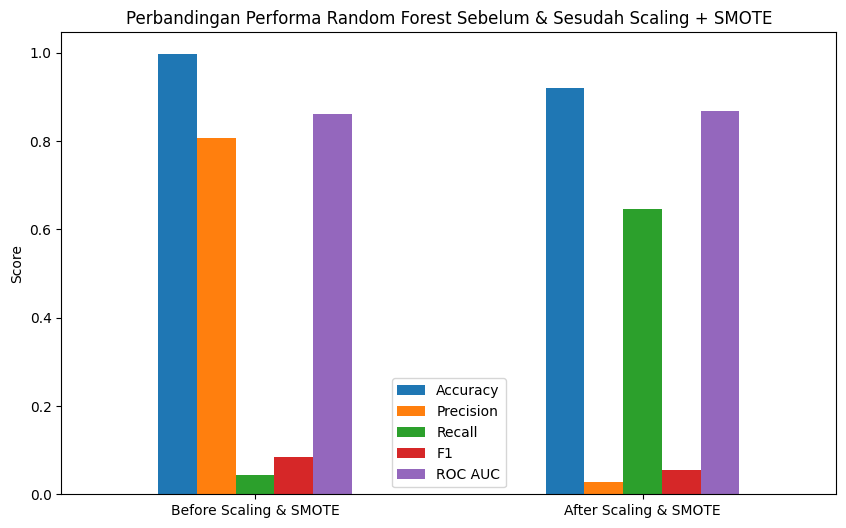

In [ ]:
# =========================
# OPSIONAL: VISUALISASI PERBANDINGAN
# =========================
import matplotlib.pyplot as plt

comp_df[['Accuracy','Precision','Recall','F1','ROC AUC']].plot(kind='bar', figsize=(10,6))
plt.title('Perbandingan Performa Random Forest Sebelum & Sesudah Scaling + SMOTE')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Analisis Komparasi Performa Random Forest

## 1. Performa Sebelum Scaling & SMOTE

| Metric    | Score       |
|-----------|------------|
| Accuracy  | 0.9965     |
| Precision | 0.8065     |
| Recall    | 0.0442     |
| F1        | 0.0838     |
| ROC AUC   | 0.8610     |

**Interpretasi:**

- Accuracy sangat tinggi (99.65%), tetapi ini **menipu** karena dataset tidak seimbang. Model cenderung memprediksi kelas mayoritas.  
- Precision tinggi (0.81), menunjukkan prediksi positif sebagian kecil yang ada sebagian besar benar.  
- Recall sangat rendah (0.044), artinya model **hampir tidak mendeteksi kasus minoritas**.  
- F1 score rendah (0.084) → keseimbangan antara precision dan recall buruk.  
- ROC AUC 0.861 menunjukkan model masih mampu membedakan kelas positif dan negatif, meskipun threshold default 0.5 tidak optimal.

---

## 2. Performa Setelah Scaling & SMOTE

| Metric    | Score       |
|-----------|------------|
| Accuracy  | 0.9195     |
| Precision | 0.0289     |
| Recall    | 0.6466     |
| F1        | 0.0553     |
| ROC AUC   | 0.8688     |

**Interpretasi:**

- Accuracy turun (91.95%) → karena model sekarang **lebih sensitif terhadap kelas minoritas**, sehingga banyak prediksi negatif menjadi positif.  
- Precision turun drastis (0.029) → sebagian besar prediksi positif salah, karena minoritas masih relatif sedikit dibanding mayoritas.  
- Recall meningkat tajam (0.647) → model sekarang **mampu mendeteksi sebagian besar kasus minoritas**.  
- F1 score masih rendah (0.055) → meskipun recall tinggi, precision sangat rendah sehingga F1 tetap rendah.  
- ROC AUC sedikit meningkat (0.869) → kemampuan model membedakan kelas positif dan negatif membaik setelah balancing.

---

## 3. Kesimpulan

- **Sebelum scaling & SMOTE:** Model fokus pada kelas mayoritas → akurasi tinggi tetapi gagal mendeteksi minoritas.  
- **Setelah scaling & SMOTE:** Model menjadi lebih adil terhadap kelas minoritas → recall tinggi, tetapi banyak false positive, sehingga precision dan F1 rendah.  
- **ROC AUC meningkat sedikit** → menunjukkan kemampuan diskriminasi model sebenarnya meningkat meskipun threshold default menghasilkan trade-off precision-recall yang buruk.  
- **Rekomendasi:** Untuk meningkatkan keseimbangan, dapat dilakukan **threshold tuning** atau metode **cost-sensitive learning**, sehingga recall tinggi tidak mengorbankan precision terlalu drastis.